In [14]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [18]:
d = pd.read_csv('./data/daily.csv')
d = d[4507:]
d.to_csv('./data/dailyChopped.csv')
df = pd.read_csv('./data/dailyChopped.csv')
df.head()

,Unnamed: 0,Day,Price
0,4507,20150105,3.22
1,4508,20150106,2.98
2,4509,20150107,3.08
3,4510,20150108,2.92
4,4511,20150109,2.96


In [23]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j]])
        xRes.append(res)
        yRes.append(df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [24]:
SPLIT = 0.85
xVal, yVal = singleStepSampler(df, 20)
xTrain = xVal[:int(SPLIT*len(xVal))]
yTrain = yVal[:int(SPLIT*len(yVal))]
xTest = xVal[int(SPLIT*len(xVal)):]
yTest = yVal[int(SPLIT*len(yVal)):]
(xTrain.shape, xTest.shape)

(TensorShape([1575, 20, 1]), TensorShape([278, 20, 1]))

In [25]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(20, 1)))
model.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
model.add(tf.keras.layers.LSTM(284, return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(30))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', 'mape'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 18, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 284)           360112    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4544)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                136350    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 496,621
Trainable params: 496,621
Non-trainable params: 0
________________________________________________

In [26]:
model.fit(xTrain, yTrain, epochs=25)

Epoch 1/25
50/50 [==============================] - 12s 15ms/step - loss: 0.3490 - mse: 0.7023 - mae: 0.3490 - mape: 1078006.6250
Epoch 2/25
50/50 [==============================] - 1s 11ms/step - loss: 0.2326 - mse: 0.4292 - mae: 0.2326 - mape: 981767.0625
Epoch 3/25
50/50 [==============================] - 1s 12ms/step - loss: 0.2206 - mse: 0.3918 - mae: 0.2206 - mape: 1069770.8750
Epoch 4/25
50/50 [==============================] - 1s 12ms/step - loss: 0.2005 - mse: 0.3668 - mae: 0.2005 - mape: 1056175.2500
Epoch 5/25
50/50 [==============================] - 1s 11ms/step - loss: 0.1964 - mse: 0.3580 - mae: 0.1964 - mape: 1059718.5000
Epoch 6/25
50/50 [==============================] - 1s 11ms/step - loss: 0.1593 - mse: 0.3153 - mae: 0.1593 - mape: 1046961.1875
Epoch 7/25
50/50 [==============================] - 1s 11ms/step - loss: 0.1561 - mse: 0.2984 - mae: 0.1561 - mape: 1062569.5000
Epoch 8/25
50/50 [==============================] - 1s 12ms/step - loss: 0.1445 - mse: 0.2710 - m

In [27]:
model.evaluate(xTest, yTest)

9/9 [==============================] - 1s 33ms/step - loss: 0.2093 - mse: 0.0915 - mae: 0.2093 - mape: 4.3661


[0.20930053293704987,
 0.09151479601860046,
 0.20930053293704987,
 4.366149425506592]

In [28]:
data = []
for item in xTest:
    data.append(model.predict(np.array([item])))

<AxesSubplot:>

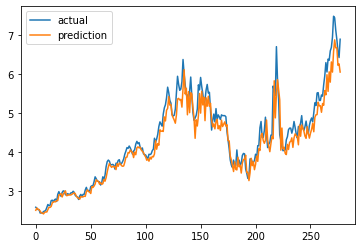

In [29]:
dafr = pd.DataFrame(data={'actual': yTest, 'prediction': [item[0][0] for item in data]})
dafr.plot()